<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 3 / NOTE 2*

# 📝 Assignment
---
# Data Wrangling


### 1) 지속적으로 여러분의 포트폴리오 데이터를 랭글링 하세요
- 여러분이 선택한 데이터들을 랭글링하여 모델을 만들기 위한 테이블 형태의 데이터로 만들어 보세요.
- **다음 함수의 result를 완성시키고 리턴값을 제출하세요.**

In [321]:
# ### 이곳에서 제출폼 과제를 진행해 주세요 ###
# import pandas as pd
# df = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/assignments/purchase_data.csv", sep=",",index_col=0)

# ## 다음 result 함수 안에 male, female 변수를 계산하세요.(groupby, get_group을 사용하세요.)
# ## sum_male: Age = 20, Gender = "Male" 그룹의 Price를 합하세요.
# ## sum_female: Age = 20, Gender = "Female" 그룹의 Price를 합하세요.

# def result(df):

#     sum_male = df[df.Age == 20].groupby('Gender')['Price'].sum().loc['Male']
#     sum_female = df[df.Age == 20].groupby('Gender')['Price'].sum().loc['Female']

#     print("sum_male: {}, sum_female: {}".format(sum_male, sum_female))
#     return round(sum_male + sum_female)

# result(df)

In [322]:
# ! pip install category_encoders

In [323]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, roc_curve, classification_report, plot_confusion_matrix, roc_auc_score
from scipy.stats import randint, uniform

In [324]:
# 자료 출처 : 서울 열린데이터 광장 - 서울특별시 부동산 실거래가 정보
# https://data.seoul.go.kr/dataList/OA-15548/S/1/datasetView.do

df = pd.read_csv('https://docs.google.com/uc?export=download&id=1WyeDe2Ry4ohJobcbnQJXHxFEAtcg-CC_', encoding='cp949')

# 서울 부동산 물건금액 예측해보기
# 1) 가격 예측
# 2) 고가 주택(9억 초과)과 고가 주택 아닌 것으로 분류(물건가격으로 특성 만든 후 물건금액 특성 제거를 통해 정보 누수 예방하기)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [325]:
# 데이터 내용물 간단하게 확인하기
df.head()

,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명
0,11290-2020-4-0000066-1,1129013800101440024,11290,성북구,1129013800,장위동,2020,4,신고,1,0.0,59.92,2,5.0,2001,아파트,749000000,0.0,래미안 장위포레카운티
1,11290-2020-4-0000628-1,1129013400105080016,11290,성북구,1129013400,길음동,2020,4,신고,1,0.0,84.77,2,18.0,2001,아파트,1200000000,0.0,롯데캐슬 클라시아
2,11530-2020-4-0014284-1,1153010200107400029,11530,구로구,1153010200,구로동,2020,4,신고,1,NaN,36.90,0,1.0,2001,아파트,105000000,1994.0,궁전아트빌라
3,11170-2020-4-0005040-1,1117011500101930000,11170,용산구,1117011500,산천동,2020,4,신고,1,NaN,59.55,0,2.0,2001,아파트,830000000,2001.0,리버힐삼성
4,11170-2020-4-0001553-1,1117012900101930003,11170,용산구,1117012900,이촌동,2020,4,신고,1,NaN,64.43,0,5.0,2001,아파트,735000000,1971.0,강변


In [326]:
df.columns

Index(['실거래가아이디', '지번코드', '시군구코드', '자치구명', '법정동코드', '법정동명', '신고년도', '업무구분코드',
       '업무구분', '물건번호', '대지권면적', '건물면적', '관리구분코드', '층정보', '건물주용도코드', '건물주용도',
       '물건금액', '건축년도', '건물명'],
      dtype='object')

In [327]:
print(df.shape)
df.isna().sum()

(176001, 19)


실거래가아이디        0
지번코드           0
시군구코드          0
자치구명           0
법정동코드          0
법정동명           0
신고년도           0
업무구분코드         0
업무구분           0
물건번호           0
대지권면적      86854
건물면적           0
관리구분코드         0
층정보        12163
건물주용도코드        0
건물주용도          0
물건금액           0
건축년도         565
건물명        12163
dtype: int64

In [328]:
# 지번코드와 법정동코드가 같은 경우가 있음
df[df['지번코드'] == df['법정동코드']].head()

,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명
9,11170-2020-4-0000318-1,1117010100,11170,용산구,1117010100,후암동,2020,4,신고,1,65.30,87.91,0,NaN,1001,단독주택,740000000,2014.0,NaN
19,11200-2020-4-0000406-1,1120011300,11200,성동구,1120011300,옥수동,2020,4,신고,1,125.00,174.51,0,NaN,1001,단독주택,1730000000,1986.0,NaN
25,11140-2020-4-0004804-1,1114011800,11140,중구,1114011800,남대문로5가,2020,4,신고,1,98.96,145.46,0,NaN,1001,단독주택,1850000000,1970.0,NaN
27,11200-2020-4-0000644-1,1120011400,11200,성동구,1120011400,성수동1가,2020,4,신고,1,105.00,149.46,0,NaN,1001,단독주택,1700000000,1993.0,NaN
31,11215-2020-4-0001845-1,1121510500,11215,광진구,1121510500,자양동,2020,4,신고,1,80.00,146.87,0,NaN,1001,단독주택,630000000,1994.0,NaN


In [329]:
# 지번 코드를 기준으로 할 것이므로 지번코드 자릿수가 19가 아닌 것을 제거
# 제거될 데이터는 전체의 10% 미만임
df = df[df['지번코드'].map(str).apply(len) == 19]

In [330]:
df[df['지번코드'].map(str).apply(len) != 19]

,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명


In [331]:
# df[df['층정보'].isna()]['건물주용도'].unique()

In [332]:
# print(df[df['건물주용도'] == '단독주택']['층정보'].unique())
# print(df[df['건물주용도'] == '단독주택']['건물명'].unique())

In [333]:
df['층정보'].unique()
# 층정보가 -1, -2, -3인 경우가 있다
# -1은 반지하일까? 그럼 -2와 -3은 도대체 무엇인가? 확인이 필요하다

array([ 5., 18.,  1.,  2.,  9.,  3.,  4., 10., 16., 12.,  7., 14., 23.,
        8.,  6., 11., 17., 15., 13., -1., 21., 19., 22., 20., 40., 24.,
       29., 26., 25., 28., 43., 34., 30., 33., 27., 36., 35., 39., 32.,
       31., 37., 38., 42., 45., 41., 44., -3., 54., 47., 61., 51., 48.,
       59., 53., 55., 49., 58., 67., 66., 46., 50., 63., -2., 60.])

In [334]:
df[df['층정보'] < 0]['건물주용도'].unique()
# 반지하 혹은 그 밑(?)으로 보이는 경우는 연립주택 또는 아파트뿐임

array(['연립주택', '아파트'], dtype=object)

In [335]:
# 반지하일 수도 있는 -1 먼저 살펴보기
df[df['층정보'].isin([-1])].head()

,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명
83,11170-2020-4-0004295-1,1117011900100020038,11170,용산구,1117011900,효창동,2020,4,신고,1,31.27,64.00,0,-1.0,2002,연립주택,405000000,1997.0,중앙그린빌라
100,11200-2020-4-0004008-1,1120011100113440099,11200,성동구,1120011100,금호동3가,2020,4,신고,1,22.92,47.00,0,-1.0,2002,연립주택,570500000,2000.0,(1344-99)
106,11200-2020-4-0004821-1,1120011500103020015,11200,성동구,1120011500,성수동2가,2020,4,신고,1,53.29,62.48,0,-1.0,2002,연립주택,402000000,1977.0,(302-15)
176,11215-2020-4-0003674-1,1121510300100450014,11215,광진구,1121510300,구의동,2020,4,신고,1,33.18,53.53,0,-1.0,2002,연립주택,130000000,2005.0,푸른빌라(45-14)
205,11170-2020-4-0005678-1,1117013100106160002,11170,용산구,1117013100,한남동,2020,4,신고,1,21.00,25.50,0,-1.0,2002,연립주택,1190000000,1993.0,(616-2)


In [336]:
# 반지하 밑(?) 데이터 살펴보기
df[df['층정보'].isin([-2, -3])].head()

,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명
24321,11590-2020-4-0013015-1,1159010500103410000,11590,동작구,1159010500,흑석동,2020,4,신고,1,NaN,84.91,0,-3.0,2001,아파트,1700000000,2019.0,아크로리버하임
62379,11200-2020-4-0007147-1,1120011300105280000,11200,성동구,1120011300,옥수동,2020,4,신고,1,NaN,76.66,0,-2.0,2001,아파트,1675000000,2016.0,옥수파크힐스101동~116동
62694,11200-2020-4-0007966-1,1120011300105280000,11200,성동구,1120011300,옥수동,2020,4,신고,1,NaN,107.99,0,-2.0,2001,아파트,2200000000,2016.0,옥수파크힐스101동~116동
69845,11170-2020-4-0009278-1,1117013100107770011,11170,용산구,1117013100,한남동,2020,4,신고,1,110.52,243.69,0,-2.0,2002,연립주택,2400000000,2005.0,(777-11)
79662,11290-2020-4-0012423-1,1129013400112870001,11290,성북구,1129013400,길음동,2020,4,신고,1,NaN,59.89,0,-2.0,2001,아파트,745000000,2019.0,롯데캐슬골든힐스


In [337]:
# 층정보 -1인 경우는 실제로 반지하일 수도 있겠으나, 데이터의 수가 전체의 약 3% 수준이라 영향이 크지 않다고 판단함
# 층정보 -2, -3인 경우는 부호 표기가 반대로 된 것으로 판단함
# 따라서 음수인 층정보는 양수로 바꾸는 것으로 처리
tmp_idx = df[df['층정보'] < 0]['층정보'].index
df.loc[tmp_idx, ['층정보']] = df[df['층정보'] < 0]['층정보'].mul(-1)
df['층정보'].unique()

array([ 5., 18.,  1.,  2.,  9.,  3.,  4., 10., 16., 12.,  7., 14., 23.,
        8.,  6., 11., 17., 15., 13., 21., 19., 22., 20., 40., 24., 29.,
       26., 25., 28., 43., 34., 30., 33., 27., 36., 35., 39., 32., 31.,
       37., 38., 42., 45., 41., 44., 54., 47., 61., 51., 48., 59., 53.,
       55., 49., 58., 67., 66., 46., 50., 63., 60.])

In [338]:
df[df['건축년도'].isna()]['건물주용도'].unique()

array(['오피스텔', '연립주택'], dtype=object)

In [339]:
df['건물주용도'].value_counts()

아파트     88542
연립주택    60351
오피스텔    14934
Name: 건물주용도, dtype: int64

In [340]:
print(df['업무구분'].unique())
print(df['업무구분코드'].unique())
print(df['물건번호'].unique())

['신고']
[4]
[  1  49  10  12   3   4   5   2 100 101 102 103 104 105 106 107 108  11
  13  14  15  16  17  18  19  21  22  23  24  25  26  27  28  29  30  31
  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  50
  51  52  53  54  55  56  57  58  59   6  60  61  62  63  64  65  66  67
  68  69   7  70  71  72  73  74  75  76  77  78  79   8  80  81  82  83
  84  85  86  87  88   9  90  91  92  93  94  95  96  97  98  99  20  89
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 147 148 149 150 146 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175]


In [341]:
print(df['관리구분코드'].unique())

['2' '0' 'B' '1' 'A']


In [342]:
print(df['건물주용도코드'].unique())
print(df['건물주용도'].unique())

[ 2001  2002 14202]
['아파트' '연립주택' '오피스텔']


In [343]:
df['건축년도'].unique()
# 건축년도가 nan 또는 0인 데이터가 있다

array([   0., 1994., 2001., 1971., 1982., 1993., 2002., 2017., 1998.,
       2016., 2000., 2018., 1997., 2003., 1996., 2013., 2019., 1977.,
       1986., 1989., 2006., 2014., 1999., 2007., 2004., 2008., 2012.,
       1990., 1978., 2015., 1991., 2020., 2009., 1985., 2005., 1992.,
       1983., 1987., 1995., 2011., 1984., 2010.,   nan, 1981., 1979.,
       1988., 1974., 1980., 1972., 1976., 1969., 1975., 1967., 2021.,
       1961., 1970., 1973., 1968., 1959., 1966., 1965., 1964.])

In [344]:
print(df.shape)
len(df[(df['건축년도'] == 0) | (df['건축년도'].isna())])

(163827, 19)


1711

In [345]:
# 전체 데이터의 약 1% 이므로 제거
df = df[(df['건축년도'] != 0) & ~(df['건축년도'].isna())]
len(df[(df['건축년도'] == 0) | (df['건축년도'].isna())])

0

In [346]:
print(df.shape)
df.isna().sum()

(162116, 19)


실거래가아이디        0
지번코드           0
시군구코드          0
자치구명           0
법정동코드          0
법정동명           0
신고년도           0
업무구분코드         0
업무구분           0
물건번호           0
대지권면적      86843
건물면적           0
관리구분코드         0
층정보            0
건물주용도코드        0
건물주용도          0
물건금액           0
건축년도           0
건물명            0
dtype: int64

In [347]:
df.head()

,실거래가아이디,지번코드,시군구코드,자치구명,법정동코드,법정동명,신고년도,업무구분코드,업무구분,물건번호,대지권면적,건물면적,관리구분코드,층정보,건물주용도코드,건물주용도,물건금액,건축년도,건물명
2,11530-2020-4-0014284-1,1153010200107400029,11530,구로구,1153010200,구로동,2020,4,신고,1,NaN,36.90,0,1.0,2001,아파트,105000000,1994.0,궁전아트빌라
3,11170-2020-4-0005040-1,1117011500101930000,11170,용산구,1117011500,산천동,2020,4,신고,1,NaN,59.55,0,2.0,2001,아파트,830000000,2001.0,리버힐삼성
4,11170-2020-4-0001553-1,1117012900101930003,11170,용산구,1117012900,이촌동,2020,4,신고,1,NaN,64.43,0,5.0,2001,아파트,735000000,1971.0,강변
5,11170-2020-4-0001992-1,1117013000100220002,11170,용산구,1117013000,이태원동,2020,4,신고,1,NaN,105.75,0,9.0,2001,아파트,1430000000,1982.0,청화1
6,11170-2020-4-0003752-1,1117011000100020033,11170,용산구,1117011000,청파동2가,2020,4,신고,1,43.9,73.04,0,3.0,2002,연립주택,400000000,1993.0,(2-33)


In [348]:
# 층정보와 건물명이 없는 데이터는 모두 단독주택이므로 층정보는 2로 대체
# (건축법 상 단독주택(단독주택/다중주택/다가구주택)은 3개 층 이하로 제한되어 있음 -> 1~3의 중간값인 2로 대체)
# 참고 : https://justdim.tistory.com/146
df['층정보'] = df['층정보'].fillna(2)

In [349]:
# 불필요한 컬럼 제거

# # 대지권면적은 결측치가 대다수이므로 제거
# # 참고 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ctrfindit&logNo=221272287733
# df = df.drop('대지권면적', axis=1)

# # 실제로 건물명이 가격에 영향을 줄 것이라는 심증이 있으나(브랜드 가치 등의 이유),
# # 현재로서는 처리할 방법을 모르기 때문에 건물명 컬럼은 제거
# df = df.drop('건물명', axis=1)

# # 실거래가아이디는 거래 자체의 고유 번호이므로 가격과 관련없다고 판단하여 컬럼 제거
# df = df.drop('실거래가아이디', axis=1)

# # 법정동코드는 지번코드에서 '필지구분(1)+본번(4)+부번(4)'을 제외한 것으로서, 지번코드가 법정동코드의 정보를 반영한다고 봄
# # 따라서 법정동코드 컬럼 제거. 시군구코드도 지번코드에 포함되므로 컬럼 제거.
# # 자치구명, 법정동명 또한 지번코드가 모두 반영하므로 컬럼 제거
# # 참고 : https://zelkun.tistory.com/entry/%EB%B2%95%EC%A0%95%EB%8F%99%ED%96%89%EC%A0%95%EB%8F%99-%EC%B0%A8%EC%9D%B4%EC%A0%90-%EB%B0%8F-%EA%B5%AC%EB%B3%84%ED%98%84%ED%99%A9
# df = df.drop(['법정동코드', '시군구코드', '자치구명', '법정동명'], axis=1)

# # 모든 데이터가 2020년에 신고된 거래 데이터이므로 신고년도는 불필요함. 컬럼 제거
# df = df.drop('신고년도', axis=1)

# # 업무구분 모두 '신고'이고, 업무구분코드도 모두 이에 해당하는 '4'임
# # 그 이전에 컬럼 자체도 불필요하다고 판단함. 따라서 컬럼 제거
# df = df.drop(['업무구분', '업무구분코드'], axis=1)

# # 물건번호는 경매에서 각 물건에 붙는 번호를 의미함
# # 예를 들어 한 사건에 한 개 물건이면 물건번호는 1임.
# # 일종의 고유 번호이므로 물건가격과 상관없다고 판단하여 컬럼 제거
# # 참고 : https://m.blog.naver.com/maestron1/221534254422
# df = df.drop('물건번호', axis=1)

# # 관리구분코드는 공공기관 내부적으로 사용하는 것으로 추정
# # 자세한 내용은 확인할 수 없었음
# # 명칭으로 보아 물건가격과는 관련이 없다고 보고 컬럼 제거
# df = df.drop('관리구분코드', axis=1)

# # 건물주용도코드가 건물주용도를 반영하고 있으므로 건물주용도 컬럼 제거
# df = df.drop('건물주용도', axis=1)

# 위 과정 한꺼번에 정리한 결과 가져오기
df = df[['지번코드',	'건물면적',	'층정보',	'건물주용도코드',	'물건금액',	'건축년도']]

In [350]:
df.isna().sum()

지번코드       0
건물면적       0
층정보        0
건물주용도코드    0
물건금액       0
건축년도       0
dtype: int64

### 2) 새로 특징들을 만들어 보세요
- 여러분이 선택한 데이터에서 특징 공학을 수행해 보세요.
- **(다중선택) purchase_data를 랭글링하여 다음 조건을 계산하고 결과가 올바른 항목을 세요.**
    1. 나이 1-20세 그룹(20세 포함)의 평균 Price는 3.101818이다.
    2. 나이 21-50세 그룹의 평균 Price는 3.021559이다.
    3. 가장 많이 구입한 아이템의 ID는 178 이다.
    4. 두번째로 매출을 많이 낸 아이템 ID는 145이다.

In [351]:
# ### 이곳에서 제출폼 과제를 진행해 주세요 ###
# # 그룹별 Price 평균
# df['Age_group'] = df['Age'].apply(lambda x: 'young' if x <= 20 else 'old')
# print(df.groupby('Age_group')['Price'].mean())
# # 1-20 = 3.101818 / 21-50 = 3.021559

# # 판매수 상위 Item ID
# print(df['Item ID'].value_counts())
# # 1위 : 178

# # 매출 상위 Item IDs
# df['Sales'] = df['Item ID'].value_counts()[df['Item ID']].reset_index(drop=True) * df['Price']
# df.groupby('Item ID').mean().sort_values(by='Sales', ascending=False)['Sales']
# # 두 번째로 매출을 많이 낸 아이템 ID : 82

In [352]:
df.head()

,지번코드,건물면적,층정보,건물주용도코드,물건금액,건축년도
2,1153010200107400029,36.90,1.0,2001,105000000,1994.0
3,1117011500101930000,59.55,2.0,2001,830000000,2001.0
4,1117012900101930003,64.43,5.0,2001,735000000,1971.0
5,1117013000100220002,105.75,9.0,2001,1430000000,1982.0
6,1117011000100020033,73.04,3.0,2002,400000000,1993.0


In [353]:
# 건축년도를 그대로 사용하기보다는 몇 년이나 오래 되었는지 나타내는 컬럼이 필요하지 않을까?
df['연식'] = (2020 - df['건축년도']).astype(int)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,지번코드,건물면적,층정보,건물주용도코드,물건금액,건축년도,연식
2,1153010200107400029,36.90,1.0,2001,105000000,1994.0,26
3,1117011500101930000,59.55,2.0,2001,830000000,2001.0,19
4,1117012900101930003,64.43,5.0,2001,735000000,1971.0,49
5,1117013000100220002,105.75,9.0,2001,1430000000,1982.0,38
6,1117011000100020033,73.04,3.0,2002,400000000,1993.0,27


In [354]:
# 건물면적을 통해 집을 소형/중형/대형으로 구분하면 어떨까?
# 기준 : 60㎡ 이하 = 소형 / 60㎡ 초과~85㎡ 이하 = 중형 / 85㎡ 초과 = 대형
# 참고 : https://www.hani.co.kr/arti/economy/property/689578.html
df['주택규모'] = df['건물면적'].apply(lambda x: 'S' if x <= 60 else 'L' if x > 85 else 'M')
df.head()

,지번코드,건물면적,층정보,건물주용도코드,물건금액,건축년도,연식,주택규모
2,1153010200107400029,36.90,1.0,2001,105000000,1994.0,26,S
3,1117011500101930000,59.55,2.0,2001,830000000,2001.0,19,S
4,1117012900101930003,64.43,5.0,2001,735000000,1971.0,49,M
5,1117013000100220002,105.75,9.0,2001,1430000000,1982.0,38,L
6,1117011000100020033,73.04,3.0,2002,400000000,1993.0,27,M


In [355]:
# 물건금액 9억 초과를 기준으로 고가주택과 고가주택이 아닌 물건으로 분류 예측은 어떨까?
# 2020년 기준 고가주택 기준 : 9억
# 참고 : https://m.post.naver.com/viewer/postView.nhn?volumeNo=32576102&memberNo=36833282
df['고가주택여부'] = df['물건금액'].apply(lambda x: 1 if x > 900000000 else 0)
df.head()

,지번코드,건물면적,층정보,건물주용도코드,물건금액,건축년도,연식,주택규모,고가주택여부
2,1153010200107400029,36.90,1.0,2001,105000000,1994.0,26,S,0
3,1117011500101930000,59.55,2.0,2001,830000000,2001.0,19,S,0
4,1117012900101930003,64.43,5.0,2001,735000000,1971.0,49,M,0
5,1117013000100220002,105.75,9.0,2001,1430000000,1982.0,38,L,1
6,1117011000100020033,73.04,3.0,2002,400000000,1993.0,27,M,0


In [356]:
df.dtypes

지번코드        object
건물면적       float64
층정보        float64
건물주용도코드      int64
물건금액         int64
건축년도       float64
연식           int64
주택규모        object
고가주택여부       int64
dtype: object

In [357]:
# 층정보, 건축년도는 int로 형변환하여 소수점 제거
df[['층정보', '건축년도']] = df[['층정보', '건축년도']].astype(int)

# 층정보, 건축년도, 건물주용도코드는 연속적인 수치형이 아닌 범주형으로 간주하여 컬럼 형변환
df[['층정보', '건축년도', '건물주용도코드']] = df[['층정보', '건축년도', '건물주용도코드']].astype(str)

df.dtypes

지번코드        object
건물면적       float64
층정보         object
건물주용도코드     object
물건금액         int64
건축년도        object
연식           int64
주택규모        object
고가주택여부       int64
dtype: object

In [358]:
# 컬럼명 변경하기
df.columns = ['addr_code', 'size', 'floor', 'type', 'price', 'built_year', 'years', 'size_grade', 'is_high_price']
df.head()

,addr_code,size,floor,type,price,built_year,years,size_grade,is_high_price
2,1153010200107400029,36.90,1,2001,105000000,1994,26,S,0
3,1117011500101930000,59.55,2,2001,830000000,2001,19,S,0
4,1117012900101930003,64.43,5,2001,735000000,1971,49,M,0
5,1117013000100220002,105.75,9,2001,1430000000,1982,38,L,1
6,1117011000100020033,73.04,3,2002,400000000,1993,27,M,0


## 🔥 도전과제

### 3) 조금 부족하더라도 최소한의 랭글링으로 데이터를 준비하여 간단한 모델을 학습시켜 보세요
- 여러분들이 선택한 데이터를 가지고 간단한 모델을 학습하고 결과를 리포팅 합니다.

In [359]:
df.describe()

,size,price,years,is_high_price
count,162116.000000,1.621160e+05,162116.000000,162116.000000
mean,62.211978,5.821901e+08,17.171266,0.171754
std,30.265012,5.120346e+08,10.780318,0.377167
min,10.290000,2.000000e+07,-1.000000,0.000000
25%,40.350000,2.420000e+08,8.000000,0.000000
50%,59.430000,4.150000e+08,17.000000,0.000000
75%,84.550000,7.560000e+08,25.000000,0.000000
max,488.540000,7.750000e+09,61.000000,1.000000


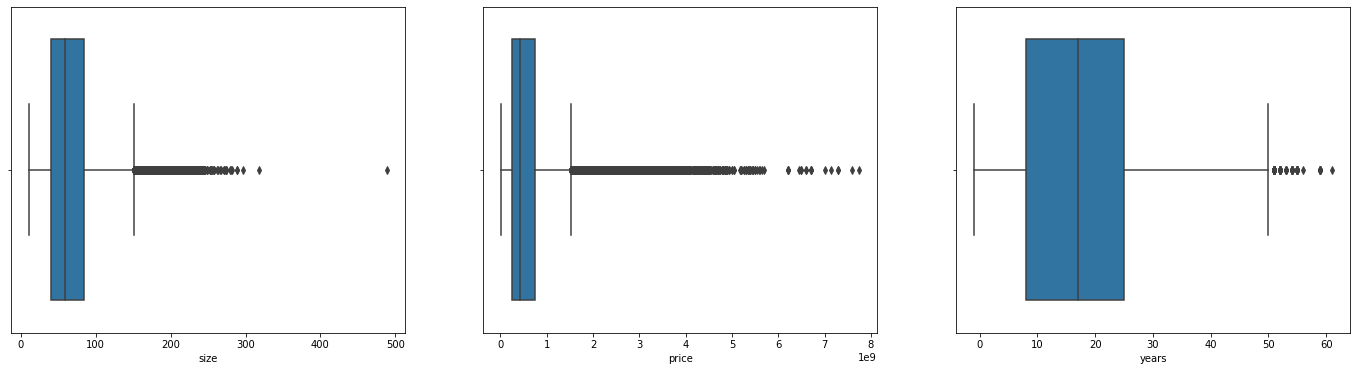

In [360]:
col_list = ['size', 'price', 'years']

def checkOutlier(df, cols):
  fig, axes = plt.subplots(1, 3, figsize=(24, 6))
  for i, col in enumerate(col_list):
    sns.boxplot(x=col, data=df, ax=axes[i])

checkOutlier(df, col_list)

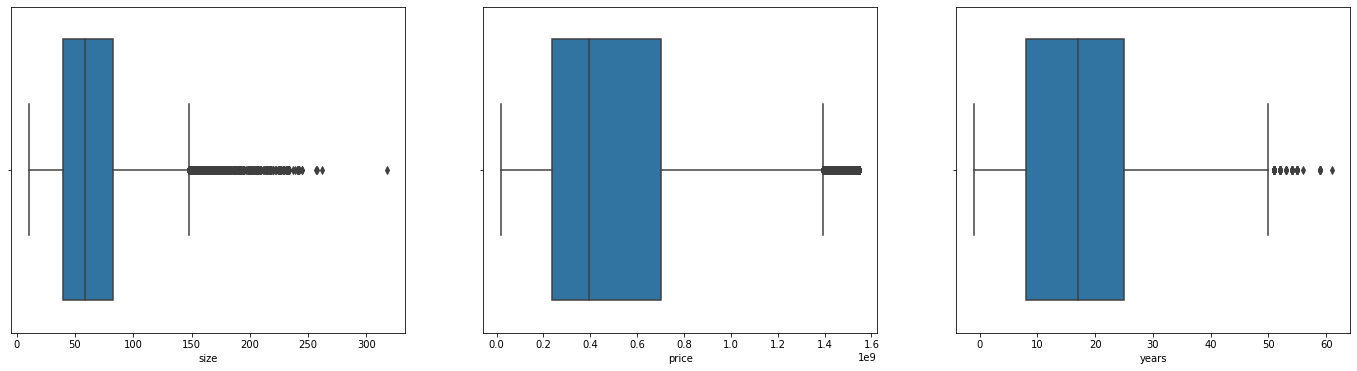

In [361]:
# 수치형 컬럼 전체적으로 이상치로 보이는 값들이 존재함
# 각각에 대하여 상위 5%를 제거
target = 'price'
df = df[df[target] < np.percentile(df[target], 95)]
checkOutlier(df, col_list)

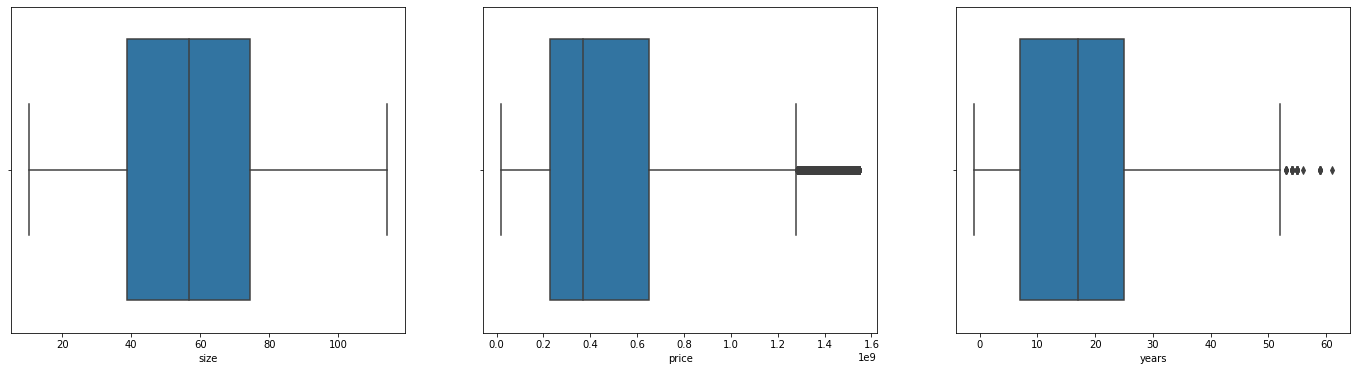

In [362]:
df = df[df['size'] < np.percentile(df['size'], 95)]
checkOutlier(df, col_list)

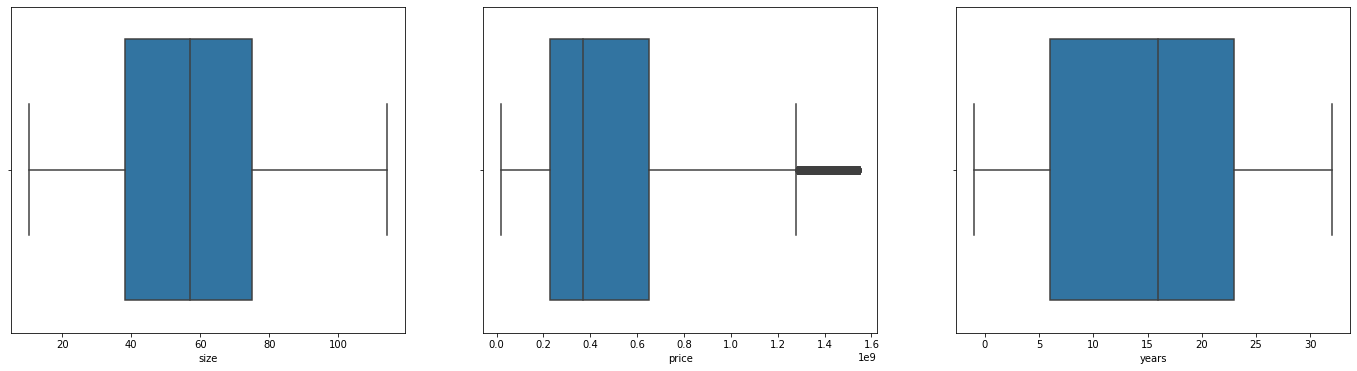

In [363]:
df = df[df['years'] < np.percentile(df['years'], 95)]
checkOutlier(df, col_list)

In [364]:
# 인덱스 재정렬
df = df.reset_index(drop=True)

df.head()

,addr_code,size,floor,type,price,built_year,years,size_grade,is_high_price
0,1153010200107400029,36.90,1,2001,105000000,1994,26,S,0
1,1117011500101930000,59.55,2,2001,830000000,2001,19,S,0
2,1117011000100020033,73.04,3,2002,400000000,1993,27,M,0
3,1120010400100530000,23.61,10,14202,313000000,2017,3,S,0
4,1117012900103950000,59.22,4,2001,1050000000,1994,26,S,1


In [365]:
df.shape

(136392, 9)

In [366]:
# 특성과 타겟(price)의 상관관계 보기
df.corr()

,size,price,years,is_high_price
size,1.000000,0.661793,0.276009,0.343700
price,0.661793,1.000000,0.048802,0.736738
years,0.276009,0.048802,1.000000,-0.052729
is_high_price,0.343700,0.736738,-0.052729,1.000000


470946234.08997595


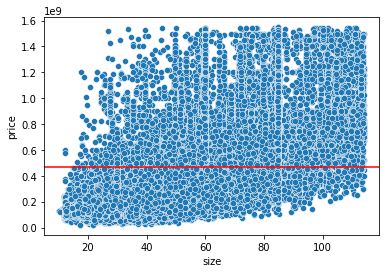

In [367]:
# 가장 상관관계가 높은 size와 타겟(price)의 관계 시각화해보기
baseline = df.price.mean() # 기준 모델 : 타겟(price)의 평균값
print(baseline)

sns.scatterplot(x='size', y='price', data=df)
plt.axhline(baseline, color='red'); # 기준 모델 시각화

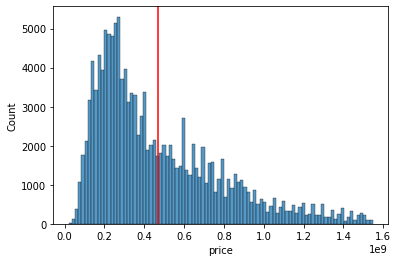

In [368]:
# 타겟(price)의 분포 확인해보기
sns.histplot(df.price, kde=False);
plt.axvline(baseline, color='red'); # 기준 모델 시각화
# price는 right-skewed이므로 로그 변환이 필요

In [369]:
# 기준 성능(회귀)
errors = baseline - df.price
baseline_mae = errors.abs().mean()
baseline_mae

254535177.4446938

0    0.895478
1    0.104522
Name: is_high_price, dtype: float64

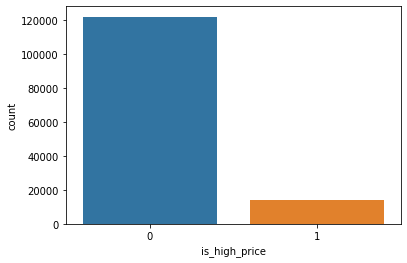

In [370]:
# 타겟(is_high_price)의 클래스 비율 확인해보기 - 기준 성능(분류)
sns.countplot(x=df.is_high_price);
df.is_high_price.value_counts(normalize=True)
# is_high_price는 클래스 비율이 불균형하므로 학습 시 class_weight 관련 설정이 필요

In [371]:
# 물건가격 예측은 회귀, 고가주택여부는 분류
# 회귀 : 릿지 회귀, 결정 트리, 랜덤 포레스트
# 분류 : 로지스틱 회귀, 결정 트리, 랜덤 포레스트

# 훈련 / 검증 / 테스트 셋으로 분리
train, test = train_test_split(df, test_size=0.30, random_state=2)
train, val = train_test_split(train, test_size=0.30, random_state=2)

train.shape, val.shape, test.shape

((66831, 9), (28643, 9), (40918, 9))

In [372]:
# 특성과 타겟 분리하기
target_cl = 'is_high_price' # 분류 문제 타겟
targets = [target, target_cl]
features = train.drop(columns=targets).columns

X_train = train[features]
y_train = train[target]
y_train_cl = train[target_cl]
X_val = val[features]
y_val = val[target]
y_val_cl = val[target_cl]
X_test = test[features]
y_test = test[target]
y_test_cl = test[target_cl]

X_train.head()

,addr_code,size,floor,type,built_year,years,size_grade
127762,1121510500107620000,84.60,1,2001,1996,24,M
44709,1120010700103040007,57.31,4,2002,1994,26,S
75903,1135010600105120000,59.26,9,2001,1991,29,S
55311,1129013600100901817,26.25,7,2002,2019,1,S
88322,1138010700100970003,84.84,4,2001,2004,16,M


In [373]:
# 1. 회귀
# 1-1. 릿지 회귀
alphas = [0, 0.001, 0.01, 0.1, 1]

# addr_code, type, built_year 셋은 TargetEncoder
tge_col = ['addr_code', 'type', 'built_year']
# floor, size_grade 둘은 OrdinalEncoder
ord_col = ['floor', 'size_grade']

pipe_ridge = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    StandardScaler(),    # 각 특성별 스케일을 통일시켜줌
    RidgeCV(alphas=alphas, cv=5)
)

tt_ridge = TransformedTargetRegressor(regressor=pipe_ridge,
                                func=np.log1p, inverse_func=np.expm1)

tt_ridge.fit(X_train, y_train)
print('훈련 정확도: ', tt_ridge.score(X_train, y_train))
print('검증 정확도: ', tt_ridge.score(X_val, y_val))

y_pred_ridge = tt_ridge.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'Test MAE: {mae_ridge:,.0f}')
print(f'R2 Score: {r2_ridge:,.4f}\n')

print(f'alpha: {tt_ridge.regressor_.named_steps.ridgecv.alpha_}')

훈련 정확도:  0.8348217194248839
검증 정확도:  0.7971220220172555
Test MAE: 91,176,557
R2 Score: 0.8039

alpha: 1.0


In [374]:
# 1-2. 결정 트리
pipe_dt = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    DecisionTreeRegressor(random_state=2)
)

tt_dt = TransformedTargetRegressor(regressor=pipe_dt,
                                func=np.log1p, inverse_func=np.expm1)

tt_dt.fit(X_train, y_train)
print('훈련 정확도: ', tt_dt.score(X_train, y_train))
print('검증 정확도: ', tt_dt.score(X_val, y_val))

y_pred_dt = tt_dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f'Test MAE: {mae_dt:,.0f}')
print(f'R2 Score: {r2_dt:,.4f}\n')

훈련 정확도:  0.9947084133632611
검증 정확도:  0.7733708605250275
Test MAE: 81,945,267
R2 Score: 0.7779



In [375]:
# 과적합 줄이기 및 최적화
dists = {
    'decisiontreeregressor__splitter': ['best', 'random'],
    'decisiontreeregressor__max_depth': [5, 10, 15, 20, None],
    'decisiontreeregressor__min_samples_split': randint(2, 50),
    'decisiontreeregressor__min_samples_leaf': randint(1, 50),
    'decisiontreeregressor__max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
    pipe_dt, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   51.3s finished


In [376]:
tt_dt_opt = TransformedTargetRegressor(regressor=clf.best_estimator_,
                                func=np.log1p, inverse_func=np.expm1)

tt_dt_opt.fit(X_train, y_train)
print('훈련 정확도: ', tt_dt_opt.score(X_train, y_train))
print('검증 정확도: ', tt_dt_opt.score(X_val, y_val))

y_pred_dt_opt = tt_dt_opt.predict(X_test)

mae_dt_opt = mean_absolute_error(y_test, y_pred_dt_opt)
r2_dt_opt = r2_score(y_test, y_pred_dt_opt)
print(f'Test MAE: {mae_dt_opt:,.0f}')
print(f'R2 Score: {r2_dt_opt:,.4f}\n')

훈련 정확도:  0.897963334751598
검증 정확도:  0.8532571137838542
Test MAE: 70,480,578
R2 Score: 0.8565



In [377]:
# 1-3. 랜덤 포레스트
pipe_rf = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    RandomForestRegressor(n_jobs=-1, random_state=2)
)

tt_rf = TransformedTargetRegressor(regressor=pipe_rf,
                                func=np.log1p, inverse_func=np.expm1)

tt_rf.fit(X_train, y_train)
print('훈련 정확도: ', tt_rf.score(X_train, y_train))
print('검증 정확도: ', tt_rf.score(X_val, y_val))

y_pred_rf = tt_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Test MAE: {mae_rf:,.0f}')
print(f'R2 Score: {r2_rf:,.4f}')

훈련 정확도:  0.9761256500745134
검증 정확도:  0.8723149013016995
Test MAE: 64,650,362
R2 Score: 0.8737


In [378]:
# 과적합 줄이기 및 최적화
dists_rf = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__min_samples_split': randint(2, 50),
    'randomforestregressor__min_samples_leaf': randint(1, 50),
    'randomforestregressor__max_features': uniform(0, 1)
}

clf_rf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists_rf, 
    n_iter=30, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf_rf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 12.3min finished


In [379]:
tt_rf_opt = TransformedTargetRegressor(regressor=clf_rf.best_estimator_,
                                func=np.log1p, inverse_func=np.expm1)

tt_rf_opt.fit(X_train, y_train)
print('훈련 정확도: ', tt_rf_opt.score(X_train, y_train))
print('검증 정확도: ', tt_rf_opt.score(X_val, y_val))

y_pred_rf_opt = tt_rf_opt.predict(X_test)

mae_rf_opt = mean_absolute_error(y_test, y_pred_rf_opt)
r2_rf_opt = r2_score(y_test, y_pred_rf_opt)
print(f'Test MAE: {mae_rf_opt:,.0f}')
print(f'R2 Score: {r2_rf_opt:,.4f}')

훈련 정확도:  0.9126343271715758
검증 정확도:  0.8693916751147276
Test MAE: 65,413,259
R2 Score: 0.8716


In [380]:
# 2. 분류
# 2-1. 로지스틱 회귀

# class weights 계산
# n_samples / (n_classes * np.bincount(y))
custom = len(y_train_cl)/(2*np.bincount(y_train_cl))

pipe_logis = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    StandardScaler(),    # 각 특성별 스케일을 통일시켜줌
    LogisticRegression(class_weight={False:custom[0],True:custom[1]}, random_state=2)
)

pipe_logis.fit(X_train, y_train_cl)
print('훈련 정확도: ', pipe_logis.score(X_train, y_train_cl))
print('검증 정확도: ', pipe_logis.score(X_val, y_val_cl))

y_pred_logis = pipe_logis.predict(X_test)

f1_logis = f1_score(y_test_cl, y_pred_logis)
print(f'Test F1: {f1_logis}')

훈련 정확도:  0.9607816731756221
검증 정확도:  0.9505289250427679
Test F1: 0.7885273972602739


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     25743
           1       0.72      0.84      0.77      2900

    accuracy                           0.95     28643
   macro avg       0.85      0.90      0.87     28643
weighted avg       0.96      0.95      0.95     28643

AUC score:  0.9714693180737448
idx: 1548 , threshold: 0.2976434142577524
Test F1: 0.7222272603609323


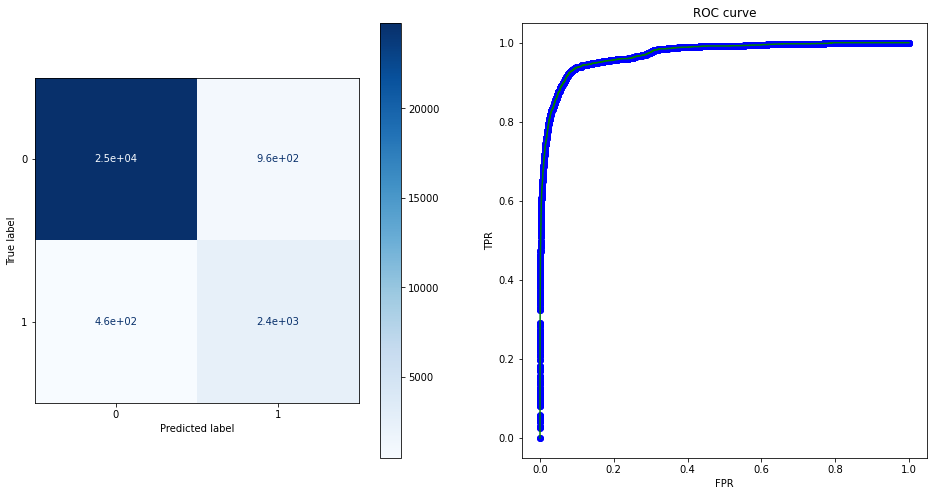

In [385]:
### 분류 문제 평가 함수
def clf_eval(model):
  fig, ax = plt.subplots(1, 2, figsize=(16, 8))
  pcm = plot_confusion_matrix(model, X_val, y_val_cl,
                              cmap=plt.cm.Blues,
                              ax=ax[0]);
  plt.title(f'Confusion matrix, n = {len(y_val_cl)}', fontsize=15)

  y_val_pred_logis = model.predict(X_val)
  print(classification_report(y_val_cl, y_val_pred_logis))

  y_val_pred_proba = model.predict_proba(X_val)[:, -1]
  print('AUC score: ', roc_auc_score(y_val_cl, y_val_pred_proba))
  fpr, tpr, thresholds = roc_curve(y_val_cl, y_val_pred_proba)
  plt.scatter(fpr, tpr, color='blue')
  plt.plot(fpr, tpr, color='green')
  plt.title('ROC curve')
  plt.xlabel('FPR')
  plt.ylabel('TPR')

  # threshold 최대값의 인덱스, np.argmax()
  optimal_idx = np.argmax(tpr - fpr) # 재현율은 최대로, 위양성률은 최소로 하는 데이터의 인덱스 값 찾기
  optimal_threshold = thresholds[optimal_idx] # 해당 값의 임계값 가져오기

  print('idx:', optimal_idx, ', threshold:', optimal_threshold)

  # 최적 임계값 적용
  y_pred_proba_logis = model.predict_proba(X_test)[:, 1] # 타겟이 1(True)일 확률 가져오기
  y_pred_logis = y_pred_proba_logis > optimal_threshold

  f1_logis = f1_score(y_test_cl, y_pred_logis)
  print(f'Test F1: {f1_logis}')

clf_eval(pipe_logis)
# 임계값 적용했는데 점수가 떨어졌다?

In [395]:
# 2-2. 결정 트리

pipe_dt = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    DecisionTreeClassifier(class_weight={False:custom[0],True:custom[1]}, random_state=2)
)

pipe_dt.fit(X_train, y_train_cl)
print('훈련 정확도: ', pipe_dt.score(X_train, y_train_cl))
print('검증 정확도: ', pipe_dt.score(X_val, y_val_cl))

y_pred_dt = pipe_dt.predict(X_test)

f1_dt = f1_score(y_test_cl, y_pred_dt)
print(f'Test F1: {f1_dt}')

훈련 정확도:  0.9947030569645823
검증 정확도:  0.9555563313898684
Test F1: 0.7977736549165121


In [396]:
# 과적합 줄이기 및 최적화
dists = {
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': [5, 10, 15, 20, None],
    'decisiontreeclassifier__min_samples_split': randint(2, 50),
    'decisiontreeclassifier__min_samples_leaf': randint(1, 50),
    'decisiontreeclassifier__max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
    pipe_dt, 
    param_distributions=dists, 
    n_iter=30, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train_cl);

print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1: ', clf.best_score_)

pipe_dt = clf.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   30.8s finished


최적 하이퍼파라미터:  {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 0.5881260804829027, 'decisiontreeclassifier__min_samples_leaf': 21, 'decisiontreeclassifier__min_samples_split': 23, 'decisiontreeclassifier__splitter': 'random'}
f1:  0.7615540828139863


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     25743
           1       0.70      0.83      0.76      2900

    accuracy                           0.95     28643
   macro avg       0.84      0.90      0.86     28643
weighted avg       0.95      0.95      0.95     28643

AUC score:  0.9425901986077233
idx: 24 , threshold: 0.4270808346101279
Test F1: 0.7739259889408763


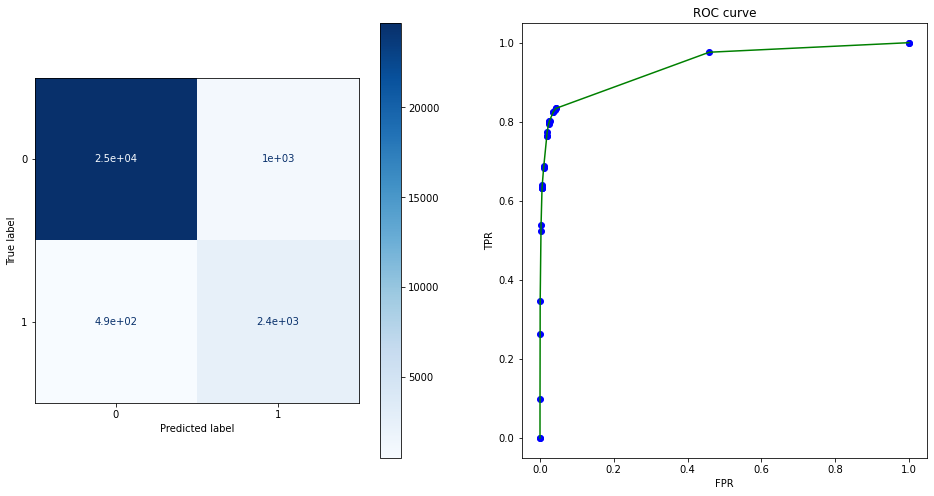

In [389]:
clf_eval(pipe_dt)
# 임계값 적용하니 점수 향상됨

In [390]:
# 2-3. 랜덤 포레스트
pipe_rf = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    RandomForestClassifier(n_jobs=-1, random_state=2)
)

pipe_rf.fit(X_train, y_train_cl)
print('훈련 정확도: ', pipe_rf.score(X_train, y_train_cl))
print('검증 정확도: ', pipe_rf.score(X_val, y_val_cl))

y_pred_rf = pipe_rf.predict(X_test)

f1_rf = f1_score(y_test_cl, y_pred_rf)
print(f'Test F1: {f1_rf}')

훈련 정확도:  0.9956457332674956
검증 정확도:  0.9650874559229131
Test F1: 0.821795336474568


In [394]:
# 과적합 줄이기 및 최적화
dists_rf = {
    'randomforestclassifier__n_estimators': randint(50, 500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__min_samples_split': randint(2, 50),
    'randomforestclassifier__min_samples_leaf': randint(1, 50),
    'randomforestclassifier__max_features': uniform(0, 1)
}

clf_rf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists_rf, 
    n_iter=30, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf_rf.fit(X_train, y_train_cl);

print('최적 하이퍼파라미터: ', clf_rf.best_params_)
print('f1: ', clf_rf.best_score_)

pipe_rf = clf_rf.best_estimator_

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.618071527646723, 'randomforestclassifier__min_samples_leaf': 13, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 377}
f1:  0.8029220550813653


              precision    recall  f1-score   support

           0       0.97      0.99      0.98     25743
           1       0.87      0.77      0.82      2900

    accuracy                           0.97     28643
   macro avg       0.92      0.88      0.90     28643
weighted avg       0.96      0.97      0.96     28643

AUC score:  0.9767850182239028
idx: 1524 , threshold: 0.09322230929192175
Test F1: 0.7414840729147486


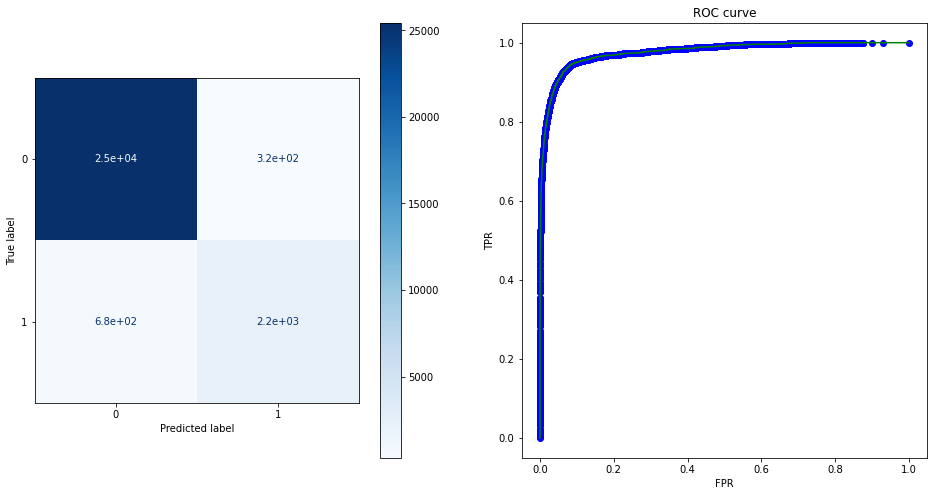

In [393]:
clf_eval(pipe_rf)
# 임계값 적용했는데 점수가 떨어졌다?